# Task 2.1b - Single-Head Regression
This notebook implements a CNN model for predicting continuous time values on images of an analog clock.

## Introduction
In this task, the goal is to predict a continuous time value from the clock images. Labels are mapped to continuous values, e.g., '3:20' → 3.33.

## Importing Libraries
We begin by importing the necessary libraries for data handling, model building, and evaluation.

In [ ]:
import requests
import zipfile
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

# Set global seeds
np.random.seed(42)
tf.random.set_seed(42)

## Loading and Preprocessing Data
In this section, we load the dataset, normalize pixel values to the range [0,1], shuffle the dataset, map labels to continuous values, and divide the data into training, validation, and test sets using an 80% / 10% / 10% split, respectively.

In [ ]:
# Download the file
# url = 'https://surfdrive.surf.nl/files/index.php/s/GsH5DxUdBgDR64B/download' # 75 x 75 pixels
url = 'https://surfdrive.surf.nl/files/index.php/s/B8emtQRGUeAaqmz/download' # 150 x 150 pixels
response = requests.get(url)

# Save the file locally
zip_filename = 'data.zip'
with open(zip_filename, 'wb') as f:
    f.write(response.content)

# Unzip the file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('unzipped_data')

# Get the names of the extracted files
extracted_files = os.listdir('unzipped_data')

# Load the NPY files containing the images and labels
image_file_path = os.path.join('unzipped_data', 'images.npy')
label_file_path = os.path.join('unzipped_data', 'labels.npy')
images = np.load(image_file_path)
labels = np.load(label_file_path)

In [ ]:
# Image dimensions
img_rows, img_cols = images.shape[1:]

# Adjust the input shape based on the image data format ('channels_first' or 'channels_last')
if keras.backend.image_data_format() == 'channels_first':
    images = images.reshape(images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    images = images.reshape(images.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Convert image array to float
images = images.astype('float32')

# Normalize the pixel intensities to [0, 1] range
images /= 255

In [ ]:
# Generate a random permutation of indices based on the number of samples
shuffle_indices = np.random.permutation(images.shape[0])

# Shuffle both images and labels using the same indices
shuffled_images = images[shuffle_indices]
shuffled_labels = labels[shuffle_indices]

In [ ]:
# Create continuous mapping
shuffled_labels_continuous = [
    h + min / 60
    for h, min in shuffled_labels
]
shuffled_labels_continuous = np.array(shuffled_labels_continuous)

# Combine continuous labels and actual times
y_data = np.hstack([
    shuffled_labels_continuous.reshape(-1, 1),  # Continuous labels
    shuffled_labels  # Actual time values (hours, minutes)
])

In [ ]:
# Split 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(shuffled_images, y_data, test_size=0.2, random_state=42)

# Split the remaining 20% into 50% validation, 50% test (i.e., 10% each of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Model Architecture
Now, we define the model structure. The CNN architecture is similar to Task 2.1a but with a single output unit and a linear activation function for continuous predictions.

In [ ]:
# Define the CNN model architecture
input_ = keras.layers.Input(shape=input_shape, name='input')
conv1 = keras.layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu', name='conv1')(input_)
conv2 = keras.layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu', name='conv2')(conv1)
maxpool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool1')(conv2)
conv3 = keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', name='conv3')(maxpool1)
conv4 = keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', name='conv4')(conv3)
maxpool2 = keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2')(conv4)
conv5 = keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv5')(maxpool2)
conv6 = keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv6')(conv5)
maxpool3 = keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool3')(conv6)
flatten = keras.layers.Flatten(name='flatten')(maxpool3)
dense1 = keras.layers.Dense(128, activation='relu', name='dense1')(flatten)
dropout1 = keras.layers.Dropout(0.3, name='dropout1')(dense1)
dense2 = keras.layers.Dense(64, activation='relu', name='dense2')(dropout1)
dropout2 = keras.layers.Dropout(0.2, name='dropout2')(dense2)
output = keras.layers.Dense(1, activation='linear', name='output')(dropout2)
model = keras.Model(inputs=[input_], outputs=[output])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 150, 150, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 150, 150, 8)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 150, 150, 8)         │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool1 (MaxPooling2D)              │ (None, 75, 75, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 75, 75, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 75, 75, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2 (MaxPooling2D)              │ (None, 37, 37, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5 (Conv2D)                       │ (None, 37, 37, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv6 (Conv2D)                       │ (None, 37, 37, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool3 (MaxPooling2D)              │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,353,593 (5.16 MB)

 Trainable params: 1,353,593 (5.16 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training
To train the 'tell-the-time' model, we implement custom loss and metric functions tailored for the regression task. Mean squared error is used as the loss function, while the 'common sense error' metric provides an intuitive accuracy measure by accounting for the cyclical nature of clock time. The model is compiled with the Adam optimizer, and performance is optimized with checkpointing to save the best model and early stopping to prevent overfitting.

In [ ]:
def custom_loss(y_true, y_pred):

    # Extract continuous labels
    y_true_continuous = tf.cast(y_true[:, 0], tf.float32)

    # Compute mean squared error manually (due to dependency issues with 'keras.losses.mean_squared_error')
    squared_difference = tf.square(y_true_continuous - y_pred)
    loss = tf.reduce_mean(squared_difference)

    return loss

In [ ]:
# Define custom metric function using TensorFlow operations
def common_sense_error(y_true, y_pred):

    # Extract actual times
    y_true_times = tf.cast(y_true[:, 1:], tf.int32)  # Hours and minutes

    # Map predicted continuous labels to time values
    hours = tf.floor(y_pred)  # Extract the integer part as hours
    hours = tf.cast(hours, tf.int32)  # Convert hours to integer type
    minutes = (y_pred - tf.cast(hours, tf.float32)) * 60  # Convert fractional part to minutes
    minutes = tf.cast(tf.round(minutes), tf.int32)  # Round to nearest minute and cast to integer
    y_pred_times = tf.stack([hours, minutes], axis=1)  # Combine hours and minutes

    # Extract hours and minutes for true and predicted times
    y_true_h, y_true_min = y_true_times[:, 0], y_true_times[:, 1]
    y_pred_h, y_pred_min = y_pred_times[:, 0], y_pred_times[:, 1]

    # Compute deltas for hours and minutes
    h_delta = y_true_h - y_pred_h
    min_delta = y_true_min - y_pred_min

    # Determine t1 and t2 based on h_delta and min_delta
    cond = tf.logical_or(h_delta > 0, tf.logical_and(h_delta == 0, min_delta >= 0))
    t1_h, t1_min = tf.where(cond, y_pred_h, y_true_h), tf.where(cond, y_pred_min, y_true_min)
    t2_h, t2_min = tf.where(cond, y_true_h, y_pred_h), tf.where(cond, y_true_min, y_pred_min)

    # Calculate hour distances and select the minimum distance
    h_dist1 = t2_h - t1_h
    h_dist2 = (12 - t2_h) + t1_h
    use_h_dist1 = h_dist1 <= h_dist2
    h_dist = tf.where(use_h_dist1, h_dist1, h_dist2)

    # Calculate minute distance
    min_dist = tf.where(
        use_h_dist1,
        tf.where(t1_min > t2_min, (60 - t1_min) + t2_min, t2_min - t1_min),
        tf.where(t2_min > t1_min, (60 - t2_min) + t1_min, t1_min - t2_min)
    )

    # Adjust hour distance if needed
    cond = tf.logical_or(tf.logical_and(use_h_dist1, t1_min > t2_min), tf.logical_and(~use_h_dist1, t2_min > t1_min))
    h_dist = tf.where(cond, h_dist - 1, h_dist)

    # Calculate total distance in minutes
    total_dist_min = h_dist * 60 + min_dist

    # Return the mean distance for the batch
    return tf.reduce_mean(total_dist_min)

In [ ]:
# Compile the model
model.compile(
    loss=custom_loss,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-4),
    metrics=[common_sense_error]
)

In [ ]:
# Define the checkpoint callback to save the best model weights based on validation loss
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'tell_the_time_CNN_regression.keras',
    save_best_only=True
)

# Define early stopping callback to stop training when validation loss stops improving
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=600,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - common_sense_error: 181.7149 - loss: 29.8516 - val_common_sense_error: 177.4667 - val_loss: 11.7380
Epoch 2/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - common_sense_error: 181.0093 - loss: 13.0736 - val_common_sense_error: 177.5333 - val_loss: 11.7572
Epoch 3/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - common_sense_error: 180.9335 - loss: 12.9755 - val_common_sense_error: 177.4000 - val_loss: 11.7392
Epoch 4/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - common_sense_error: 180.8921 - loss: 12.8984 - val_common_sense_error: 177.4667 - val_loss: 11.7415
Epoch 5/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - common_sense_error: 180.9328 - loss: 12.8496 - val_common_sense_error: 176.7333 - val_loss: 11.6255
Epoch 6/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - common_sense_error: 180.8468 - loss: 12.8364 - val_common_sense_error: 176.6667 - val_loss: 11.5997
Epoch 7/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - common_

## Evaluation
We assess the model’s performance by visualizing the training history, including loss and common sense error across epochs for both training and validation sets. This helps identify trends like overfitting or underfitting. Finally, we evaluate the model on the test set to obtain its generalization performance, reporting the final test loss and common sense error. The trained model is then saved for future use.

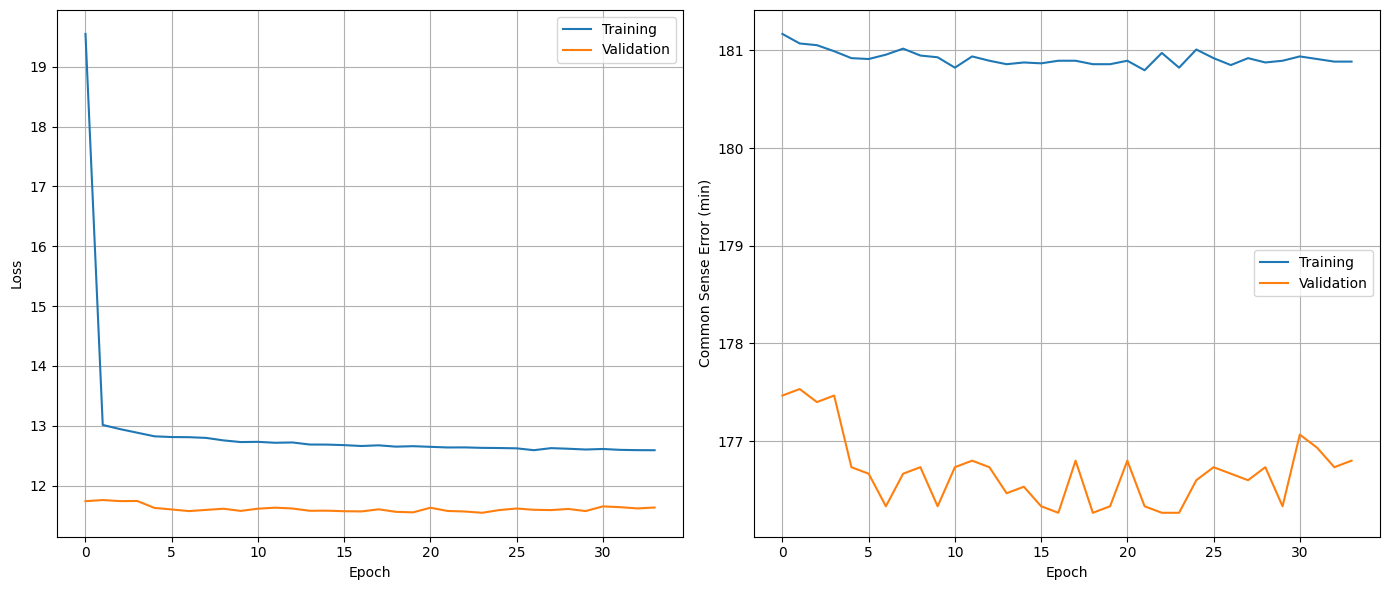

In [ ]:
# Convert the training history to a dataframe
df = pd.DataFrame(history.history)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 'loss' and 'val_loss' on the first subplot
axes[0].plot(df['loss'], label='Training')
axes[0].plot(df['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plot 'common_sense_error' and 'val_common_sense_error' on the second subplot
axes[1].plot(df['common_sense_error'], label='Training')
axes[1].plot(df['val_common_sense_error'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Common Sense Error (min)')
axes[1].legend()
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show both plots
plt.show()

In [ ]:
# Evaluate model performance on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test common sense error:', score[1])

Test loss: 12.313546180725098
Test common sense error: 182.4385986328125


In [ ]:
# Save the model
model.save('tell_the_time_CNN_regression.keras')